In [1]:
import os
# make sure that either you have the .env set up, or uncomment that code block and fill in the keys
os.environ["CUDA_VISIBLE_DEVICES"] = "9"
os.environ["MLFLOW_TRACKING_URI"] = "https://mlflow.enigmatic.stanford.edu/"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mlflow-runner"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "x3i#U9*73N75"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import torch
from torch import autocast
from mlflow.artifacts import download_artifacts
from hydra.utils import instantiate

from experanto.dataloaders import get_multisession_concat_dataloader
from monkey_baselines.model_factory import load_model
from monkey_baselines.utils.evals import get_correlation_gaze

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

Skipping import of cpp extensions due to incompatible torch version 2.7.0a0+7c8ec84dab.nv25.03 for torchao version 0.16.0             Please see https://github.com/pytorch/ao/issues/2919 for more info


cannot find .env file


In [2]:
## MLflow run IDs for the two models used in this demo:
# V3/V4 model: https://mlflow.atlab.stanford.edu/#/experiments/609269488671045964/runs/eb4b088144dd407ebeb9f4a3c70f9cad
# V1/V2/V3 model: https://mlflow.atlab.stanford.edu/#/experiments/609269488671045964/runs/fe071b4bb2b244068889f4a2cc327d69

In [3]:
model_checkpoint_path = download_artifacts(
    "mlflow-artifacts:/621818231566971674/2f85fd6f5dda46e280456d3186618e1c/artifacts/6806be20120f307fa684cd4c637ad949_final.pth.tar"
)

In [4]:
config_path = download_artifacts(
    "mlflow-artifacts:/621818231566971674/2f85fd6f5dda46e280456d3186618e1c/artifacts/6806be20120f307fa684cd4c637ad949_final_cfg.pth.tar"
)

In [5]:
cfg = torch.load(config_path, weights_only=False)
cfg = instantiate(cfg)

# Get dataloaders

In [6]:
paths = [
    "/mnt/data1/enigma/goliath_10_20_sandbox/37_3843837605846_0_V3A_V4/",
]
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataset.modality_config.screen.include_blanks = True
cfg.dataset.modality_config.screen.sample_stride = 1
train_dl = get_multisession_concat_dataloader(paths, cfg)
cfg.dataset.modality_config.screen.sample_stride = cfg.dataset.modality_config.screen.chunk_size
# override blanks for validation
cfg.dataset.modality_config.screen.include_blanks = False
cfg.dataset.modality_config.screen.valid_condition = {"tier": "validation"}
val_dl = get_multisession_concat_dataloader(paths, cfg)

cfg.dataset.modality_config.screen.include_blanks = False
cfg.dataset.modality_config.screen.valid_condition = {"tier": "test"}
test_dl = get_multisession_concat_dataloader(paths, cfg)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Dataset 0: 37_3843837605846_0_V3A_V4, length = 215312
Sessions: ['37_3843837605846_0_V3A_V4']
Batches per session: {'37_3843837605846_0_V3A_V4': 26914}
Total batches: 26914
Created FastSessionDataLoader with 1 sessions and 26914 total batches
Dataset 0: 37_3843837605846_0_V3A_V4, length = 1915
Sessions: ['37_3843837605846_0_V3A_V4']
Batches per session: {'37_3843837605846_0_V3A_V4': 239}
Total batches: 239
Created FastSessionDataLoader with 1 sessions and 239 total batches
Dataset 0: 37_3843837605846_0_V3A_V4, length = 249
Sessions: ['37_3843837605846_0_V3A_V4']
Batches per session: {'37_3843837605846_0_V3A_V4': 31}
Total batches: 31
Created FastSessionDataLoader with 1 sessions and 31 total batches


# Get model

In [7]:
dtype = getattr(torch, cfg.trainer.dtype)
skip_samples = cfg.trainer.skip_n_samples # <=== This is super important

print("model dtype: ", dtype)
model = load_model(config_path, model_checkpoint_path, train_dl, strict=True, model_type="free_viewing")

model dtype:  torch.float32


## Run inference

In [40]:
key, batch = next(iter(train_dl))

# these 3 inputs are required for inference. More details are below.
videos = batch["screen"].to("cuda", dtype, non_blocking=True)
gaze = batch["eye_tracker"][..., :2].cuda().to("cuda", dtype, non_blocking=True)
gaze_timestamps = batch["timestamps"]["eye_tracker"].to("cuda", dtype, non_blocking=True)

# ground truth neuronal responses. not an input to the model.
responses = batch["responses"].to("cuda", dtype, non_blocking=True)

# run forward pass
with torch.no_grad():
    with autocast(device_type="cuda", dtype=torch.bfloat16, enabled=cfg.trainer.amp):
        out = model(videos, key, gaze=gaze, gaze_timestamps=gaze_timestamps,)

print("responses: ", responses.shape, " (batch size, timestamps, neurons, ),  model has a context of 12 samples: 12/30 = 400ms)")
print("model output shape: ", out.shape, " (batch size, neurons, timestamps),  model has a context of 12 samples: 12/30 = 400ms)")

responses:  torch.Size([8, 12, 653])  (batch size, timestamps, neurons, ),  model has a context of 12 samples: 12/30 = 400ms)
model output shape:  torch.Size([8, 653, 12])  (batch size, neurons, timestamps),  model has a context of 12 samples: 12/30 = 400ms)


## >>> Important for inference/MEIs <<<

In [12]:
print(f"IMPORTANT!! The model is trained to predict a subset of responses, and it ignores the first {skip_samples} responses")

ground_truth_responses = responses[:, skip_samples:, :].cpu().numpy() # (batch size, valid timestamps, neurons)
predictions = out[:, :, skip_samples:].cpu().numpy() # (batch_size, neurons, valid timestamps)

print("model valid output shape: ", predictions.shape, " (batch size, neurons, [timestamps - skipped samples]), model makes valid predictions for 9 samples: 9/30 = 300ms)")

IMPORTANT!! The model is trained to predict a subset of responses, and it ignores the first 3 responses
model valid output shape:  (8, 653, 9)  (batch size, neurons, [timestamps - skipped samples]), model makes valid predictions for 9 samples: 9/30 = 300ms)


## Get validation score

In [13]:
from monkey_baselines.utils.evals import get_correlation_gaze

validation_correlation = get_correlation_gaze(
    model=model,
    dataloader=val_dl,
    amp=cfg.trainer.amp,
    valid_samples=cfg.trainer.skip_n_samples,
    dtype=dtype,
    per_session=True,
    per_neuron=True,
)

Text(0.5, 1.0, 'Validation performance on all Neurons')

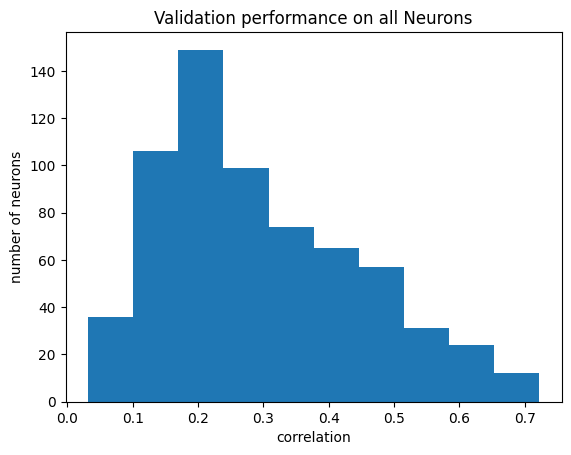

In [14]:
plt.hist(validation_correlation[key])
plt.xlabel("correlation")
plt.ylabel("number of neurons")
plt.title("Validation performance on all Neurons")

# get unit info

In [15]:
import pandas as pd

In [16]:
base_path = "/mnt/data1/enigma/goliath_10_20_sandbox/37_3843837605846_0_V3A_V4/responses_30Hz_permissive_stability_criteria/meta/"
df_anatomy = pd.read_csv(base_path + "anatomical_info.csv") # estimated brain area from all units (N=1040 originally recorded units)
df_unit_info= pd.read_csv(base_path + "unit_summary.csv") # spike sorting quality control, for actual units used in model (N=653 units)

<BarContainer object of 3 artists>

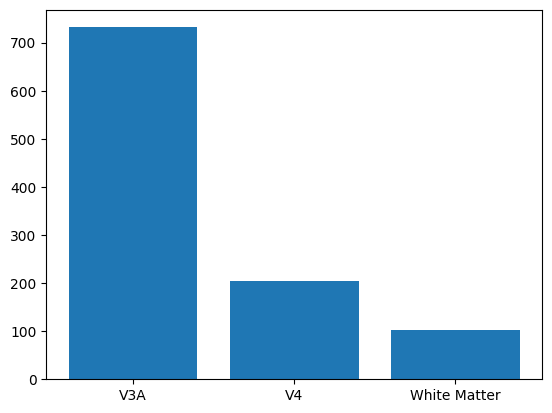

In [17]:
plt.bar(*np.unique(df_anatomy["label_name"], return_counts=True))

In [18]:
df_anatomy # All 1040 neurons

,Unnamed: 0,unit_id,unit_depth_um,matched_voxel_pos_um,delta_um,label_id,label_name
0,0,0,3763.324303,3840.0,-76.675697,0,White Matter
1,1,1,2415.414371,2340.0,75.414371,123,V3A
2,2,2,3764.891670,3840.0,-75.108330,0,White Matter
3,3,3,3749.779073,3840.0,-90.220927,0,White Matter
4,4,4,3770.891838,3840.0,-69.108162,0,White Matter
...,...,...,...,...,...,...,...
1035,1035,1035,2440.147705,2340.0,100.147705,123,V3A
1036,1036,1036,2442.865534,2340.0,102.865534,123,V3A
1037,1037,1037,106.525236,90.0,16.525236,20,V4
1038,1038,1038,140.524952,90.0,50.524952,20,V4


In [19]:
df_unit_info # 653 neurons used in modeling

,cluster_id,KSLabel,probe_id,original_unit_id,presence_ratio,good_spikes_fraction,mfr,mifr,med_isi,mode_isi,...,IR,Lv,LvR,LcV,SI,SKW,std_isi,burst_idx,acg_burst_vs_mfr,acg_oscill_vs_mfr
0,probe_imec0_1,mua,probe_imec0,1,1.000000,0.693142,6.448777,79.837902,0.065900,0.001000,...,1.671490,1.218014,49.704725,-0.586677,0.178159,1.956200,0.206413,500.00,13.047929,3.284478
1,probe_imec0_2,good,probe_imec0,2,1.000000,0.948761,21.135292,111.663492,0.020000,0.001000,...,1.322873,0.979164,76.033674,-0.345589,0.121006,2.791534,0.071419,461.54,4.394114,2.035322
2,probe_imec0_3,good,probe_imec0,3,0.944751,0.829823,1.296760,40.831511,0.163867,0.001267,...,1.680119,1.210683,23.725732,-1.031467,0.181314,4.156661,1.815359,256.41,19.918783,12.925695
3,probe_imec0_4,good,probe_imec0,4,1.000000,0.958043,10.075046,75.448825,0.036500,0.001000,...,1.441035,1.065283,51.392715,-0.457032,0.139311,2.774838,0.150049,379.75,5.558238,2.934147
4,probe_imec0_5,good,probe_imec0,5,0.988950,0.520103,4.242870,32.443699,0.066367,0.016104,...,1.172869,0.845752,21.018860,-0.584687,0.100393,3.286908,0.426497,123.46,1.657742,4.662138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,probe_imec0_1030,mua,probe_imec0,1030,1.000000,0.529599,1.055037,25.435641,0.415833,0.001000,...,1.817475,1.281142,12.639628,-1.529881,0.205578,2.756312,1.390551,111.88,13.532880,9.889340
649,probe_imec0_1033,mua,probe_imec0,1033,0.856354,0.730218,0.702371,15.278071,0.316717,0.001133,...,1.577238,1.146428,9.575059,-1.616044,0.162465,4.141456,3.204623,60.54,8.801600,12.322230
650,probe_imec0_1036,mua,probe_imec0,1036,1.000000,0.585318,0.931321,18.856705,0.473933,0.001000,...,1.790189,1.266942,10.122621,-1.715714,0.200682,2.948316,1.593493,84.72,9.888430,9.182106
651,probe_imec0_1037,mua,probe_imec0,1037,1.000000,0.565822,2.464771,40.392525,0.141233,0.001000,...,1.772670,1.274281,23.760194,-0.848070,0.195884,2.560983,0.625748,198.68,6.253824,5.600418


In [20]:
is_v4 = np.isin(df_unit_info["original_unit_id"], np.where(df_anatomy["label_name"]=="V4")[0])
is_v3a = np.isin(df_unit_info["original_unit_id"], np.where(df_anatomy["label_name"]=="V3A")[0])
is_white_matter = np.isin(df_unit_info["original_unit_id"], np.where(df_anatomy["label_name"]=="White Matter")[0])

is_sua = (df_unit_info['KSLabel']=="good")
is_mua = (df_unit_info['KSLabel']=="mua")

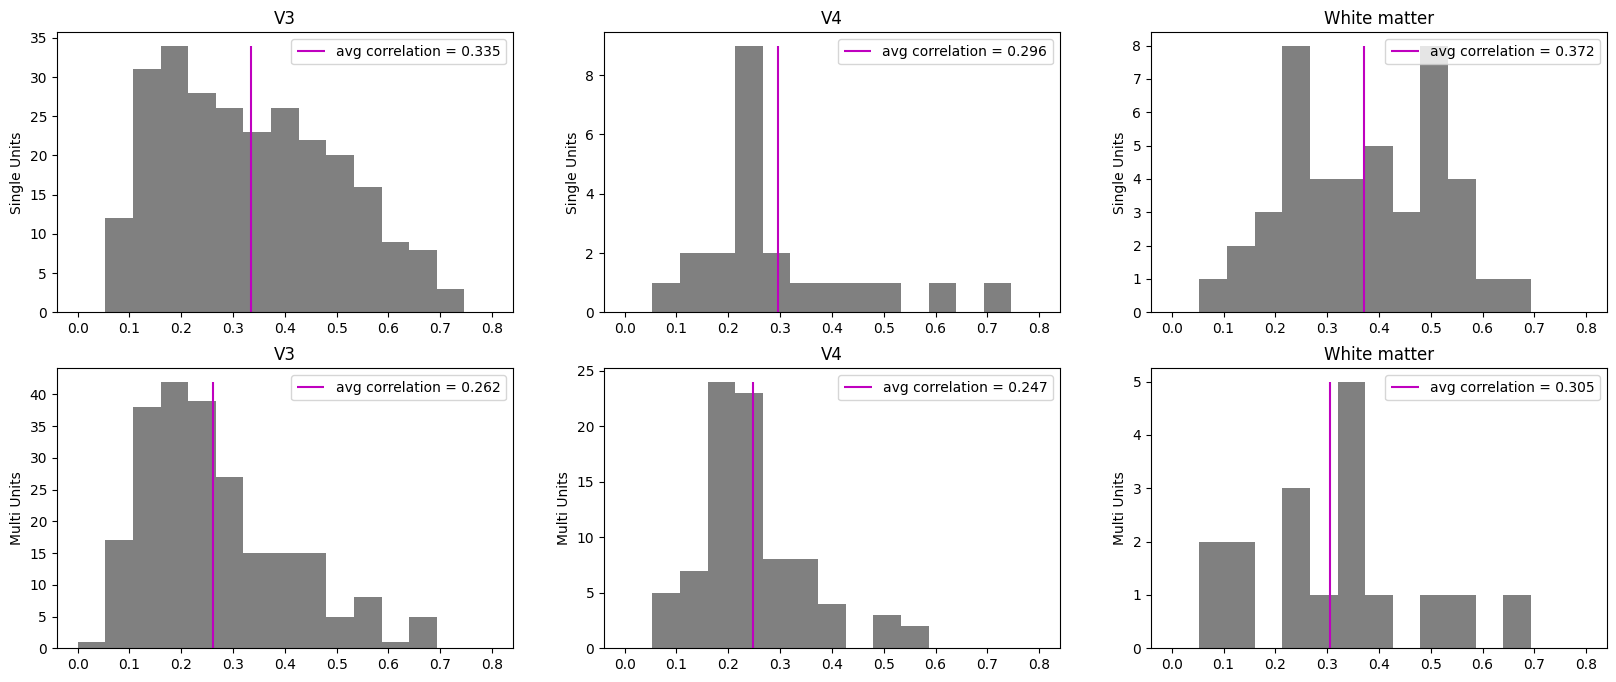

In [21]:
fig, axs = plt.subplots(2,3, figsize=(20,8))

for i, (area, label) in enumerate(zip([is_v3a, is_v4, is_white_matter], ["V3", "V4", "White matter"])):
    for j, unit_type in enumerate([is_sua, is_mua]):
        y = validation_correlation[key][area & unit_type]
        
        corr = np.round(np.nanmean(y), 3)
        hist_data = axs[j, i].hist(y, bins=np.linspace(0, .8, 16), color="gray",)
        ymax = hist_data[0].max()
        axs[j, i].vlines(corr, ymin=0, ymax=ymax, colors="m", label="avg correlation = " + str(corr))
        axs[j, i].legend()
        axs[j, i].set(
            title=label, 
            ylabel="Single Units" if j==0 else "Multi Units"
                     )

# Select units for analysis

### example

In [43]:
correlations = validation_correlation[key]
filter_corr_value = 0.4

good_v3_sua_indices = np.where((correlations > 0.4) & is_sua & is_v3a)[0] # those are the indeces of the model neurons that correspond to that filter
print(f"Indices in the model that correspond to single neurons in area V3a with a correlation > {filter_corr_value}: ")
print(good_v3_sua_indices)
# all filters:
# brain area: [is_v4, is_v3a, is_white_matter]
# units: [is_sua, is_mua]

Indices in the model that correspond to single neurons in area V3a with a correlation > 0.4: 
[ 25  26  30  32  33  37  38  41  44  46  48  50  52  53  54  57  60  61
  62  83  84  86  87  88  89  93  94  95  99 101 102 103 104 105 106 107
 108 109 110 111 112 115 116 118 121 123 127 137 144 145 166 189 228 230
 236 242 327 333 339 340 345 354 371 377 379 384 387 392 398 422 423 424
 425 429 430 441 443 447 454 458 459 468 478 488 496 521 525 532 533 535]


In [44]:
np.save('indices_v3a.npy', good_v3_sua_indices)

### select a unit

In [26]:
example_unit_index = 25
example_unit_id = df_unit_info.iloc[example_unit_index]["original_unit_id"]
print(f"unit index {example_unit_index} has corresponds to {correlations[example_unit_index]}")

unit index 25 has corresponds to 0.5054219961166382


In [31]:
print(videos.shape)
print(gaze.shape)
print(gaze_timestamps.shape)

torch.Size([8, 3, 12, 236, 420])
torch.Size([8, 12, 2])
torch.Size([8, 12])


### gaze set to zero => no eye movements

In [35]:
input_video = torch.randn(1,3,12,236, 420).cuda() # start with initial random noise video (batch, channels, t, h, w)
input_gaze = torch.zeros(1,12,2).cuda() # fix gaze to zeros => no eye movement 
input_gaze_timestamps = torch.ones(1,12).cuda() * 3600 # select a specific time in the experiment. No need to change it from this value.

In [39]:
input_video.max()

tensor(4.9362, device='cuda:0')

In [33]:
# get predictions
with torch.no_grad():
    with autocast(device_type="cuda", dtype=torch.bfloat16, enabled=cfg.trainer.amp):
        out = model(input_video, key, gaze=input_gaze, gaze_timestamps=input_gaze_timestamps,)

In [34]:
print(f"predictions over time for the selected neuron: ")
print(out[0,example_unit_index, skip_samples:])
print(f"run gradient ascent on: {out[0, example_unit_index, skip_samples:].mean()}")

predictions over time for the selected neuron: 
tensor([0.6915, 0.6202, 0.6202, 0.6669, 0.6832, 0.6589, 0.6669, 0.6354, 0.5628],
       device='cuda:0')
run gradient ascent on: 0.6450929641723633
